# Basic plots on the cleaned data
Author: Daheng Wang  
Last modified: 2017-05-19

# Road map
1. Basic tweet related plots
2. Basic user related plots

# Steps

## Initialization

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # render double resolution plot output for Retina screens 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os, sys, json, datetime, pickle
from pprint import pprint
import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING

import mongodb  # module for setting up connection with (local) MongoDB database
import multiprocessing_workers  # module for splitting workloads between processes
import utilities  # module for various custom utility functions
from config import *

# ISO8601_FMT = '%Y-%m-%dT%H:%M:%S.%fZ' # default datetime string format

## Basic tweet related plots

### Tweet number agst. datetime

In [3]:
tweet_num_agst_datetime_pkl = os.path.join(TMP_DIR,'tweet_num_agst_datetime.pkl')

_Step 1_ Check if pickle data exist. If no, query tweets ('id', parsed 'created_at') from database, and pickle into local file. 

In [6]:
if not os.path.exists(tweet_num_agst_datetime_pkl):
    print("Building pickle from database...")
    # dictiionary of data in format of {'id': 'created_at'}
    data_dict = {}
    parsed_created_at_col = mongodb.initialize(
        db_name=DB_NAME, collection_name=PARSED_CREATED_AT_COL)
    cursor = parsed_created_at_col.find(
        projection={'_id': 0,
                    'id': 1,
                    'created_at_parsed': 1})
    for doc in cursor:
        id_int64 = int(doc['id'])
        created_at_obj = doc['created_at_parsed']
        #created_at_obj = datetime.datetime.strptime(created_at_str, iso8601_fmt)
        data_dict[id_int64] = created_at_obj
    with open(tweet_num_agst_datetime_pkl, 'wb') as f:
        pickle.dump(data_dict, f)
    print('Done')
else:
    print('Pickled data found')

Building pickle from database...
MongoDB on localhost:27017/tweets_ek.c2_parsed_created_at connected successfully!
Done


_Step 2_ Load pickled data into dataframe and plot

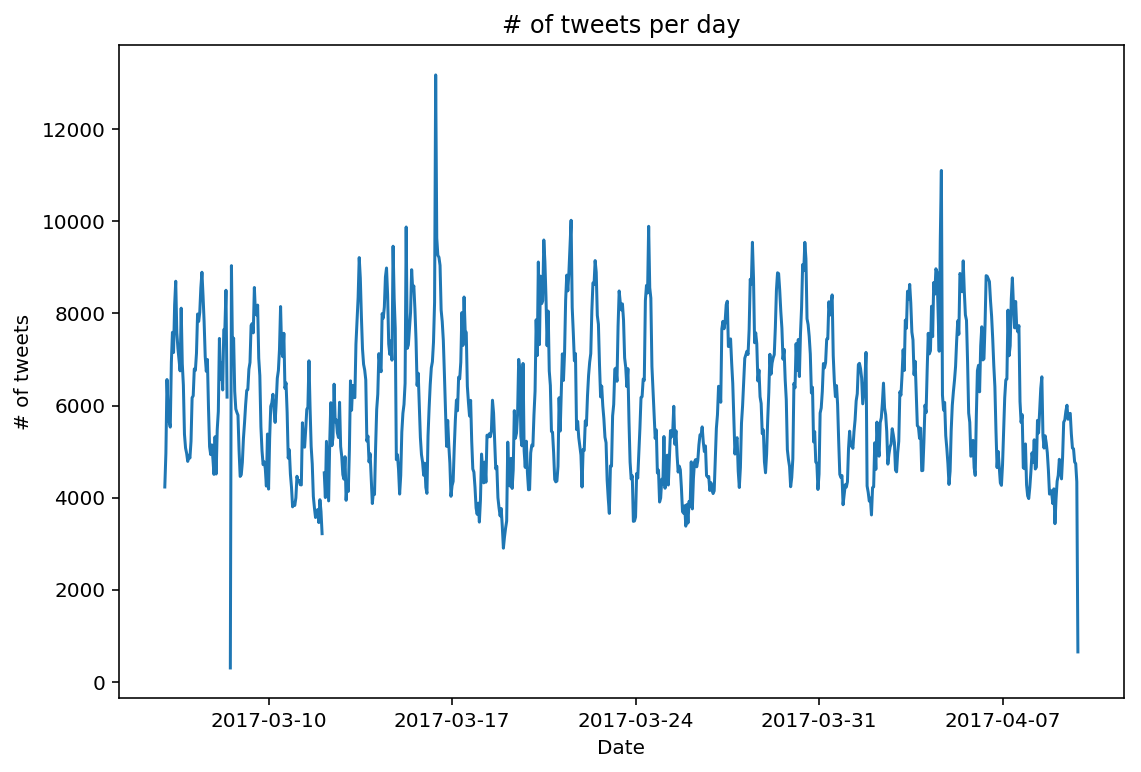

In [7]:
tweet_num_agst_datetime_fig = os.path.join(FIG_DIR, 'tweet_num_agst_datetime.png')
if 1 == 1:
    '''
    Prepare data
    '''
    data_dict = {} # dictiionary of data in format of {'id': 'created_at'}
    if not data_dict: # load data from pickle
        with open(tweet_num_agst_datetime_pkl, 'rb') as f:
            data_dict = pickle.load(f)
    
    # build DatetimeIndex
    dt_ind = pd.to_datetime(list(data_dict.values()), utc=True) # only timestamp information needed here for plotting
    
    ts = pd.Series(data=np.ones_like(dt_ind, dtype=int), # fill 'num' column with 1
                  index=dt_ind,
                  dtype=int,
                  name='num')

    # resample DatetimeIndex hourly
    ts_new = ts.resample(rule='1h').sum()
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    ax.set_title('# of tweets per day')
    ax.set_xlabel('Date')
    ax.set_ylabel('# of tweets')

    plt.plot(ts_new)
    
    
    '''
    Save figure
    '''
    plt.savefig(tweet_num_agst_datetime_fig, dpi=200)

## Basic user related plots

### followers_count/friends_count against user's rank

In [16]:
followers_and_friends_count_pkl = os.path.join(TMP_DIR,'followers_and_friends_count.pkl')
followers_count_fig = os.path.join(FIG_DIR, 'followers_count.png')
friends_count_fig = os.path.join(FIG_DIR, 'friends_count.png')

_Step 1_ Check if pickle data exist. If no, query tweets ('id', 'followers_count') from database, and pickle into local file.

In [17]:
if not os.path.exists(followers_and_friends_count_pkl):
    print("Building pickle from database...")
    # list of dictionaries in format {'id': int, 'followers_count': int, 'friends_count': int}
    data_lst = []

    user_col = mongodb.initialize(db_name=DB_NAME, collection_name=USERS_COL)
    cursor = user_col.find(projection={
        '_id': 0,
        'id': 1,
        'followers_count': 1,
        'friends_count': 1
    })
    for doc in cursor:
        data_lst.append(dict(doc))

    with open(followers_and_friends_count_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')
else:
    print('Pickled data found')

Pickled data found


_Step 2_ Load pickled data into dataframe and plot

In [18]:
if 0 == 1:
    data_lst = [] # dictiionary of data in format of {'id': 'followers_count'}
    if not data_lst: # load data from pickle
        with open(followers_and_friends_count_pkl, 'rb') as f:
            data_lst = pickle.load(f)
    
    df = pd.DataFrame(data=data_lst,
                      columns=['id', 'followers_count', 'friends_count'],
                      dtype=int)
    df = df.set_index('id')
    
    # compute user's rank information by 'followers_count' and 'friends_count'
    df['followers_count_rank'] = df['followers_count'].rank(method='first', ascending=False)
    df['friends_count_rank'] = df['friends_count'].rank(method='first', ascending=False)

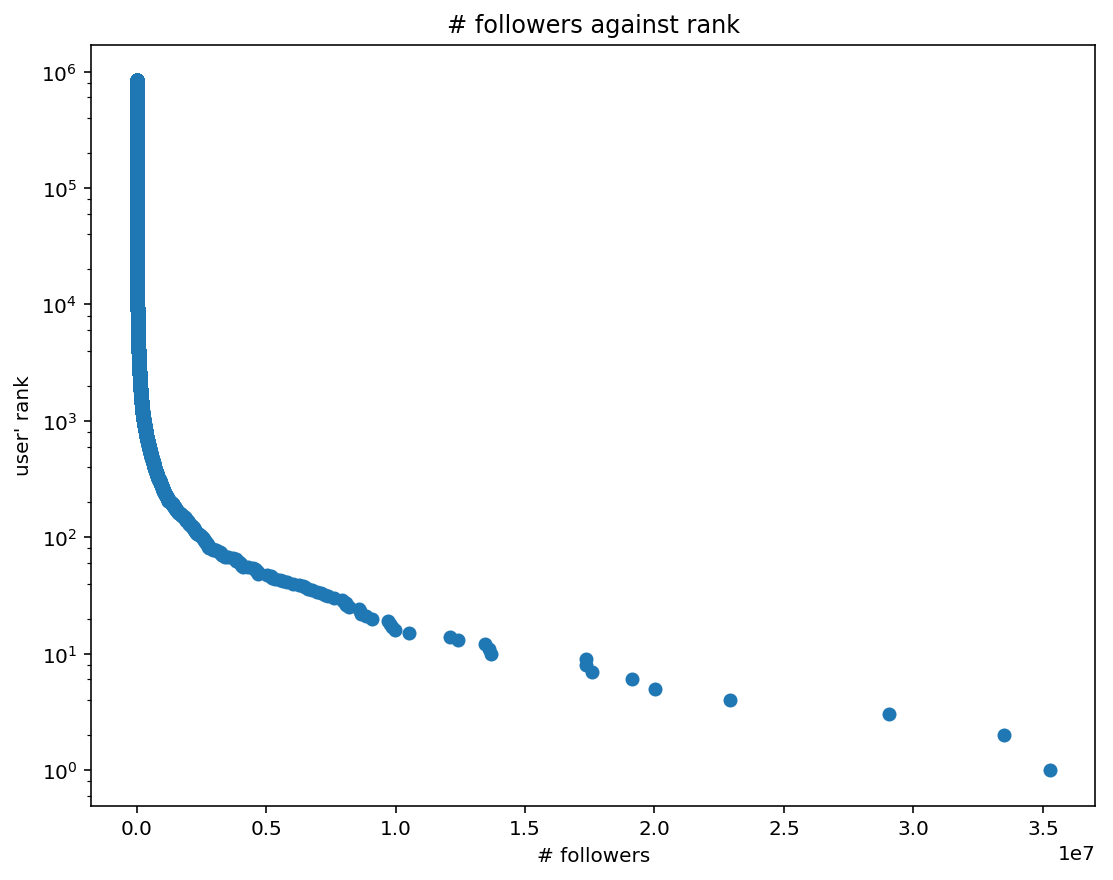

In [53]:
if 0 == 1:
    # plot and save figure   
    plt.figure(figsize=(9,7))
    plt.title('# followers against rank')
    plt.xlabel('# followers')
    plt.ylabel('user\' rank')
    plt.yscale('log')
    plt.scatter(x = df['followers_count'], y = df['followers_count_rank'])
    plt.savefig(followers_count_fig)

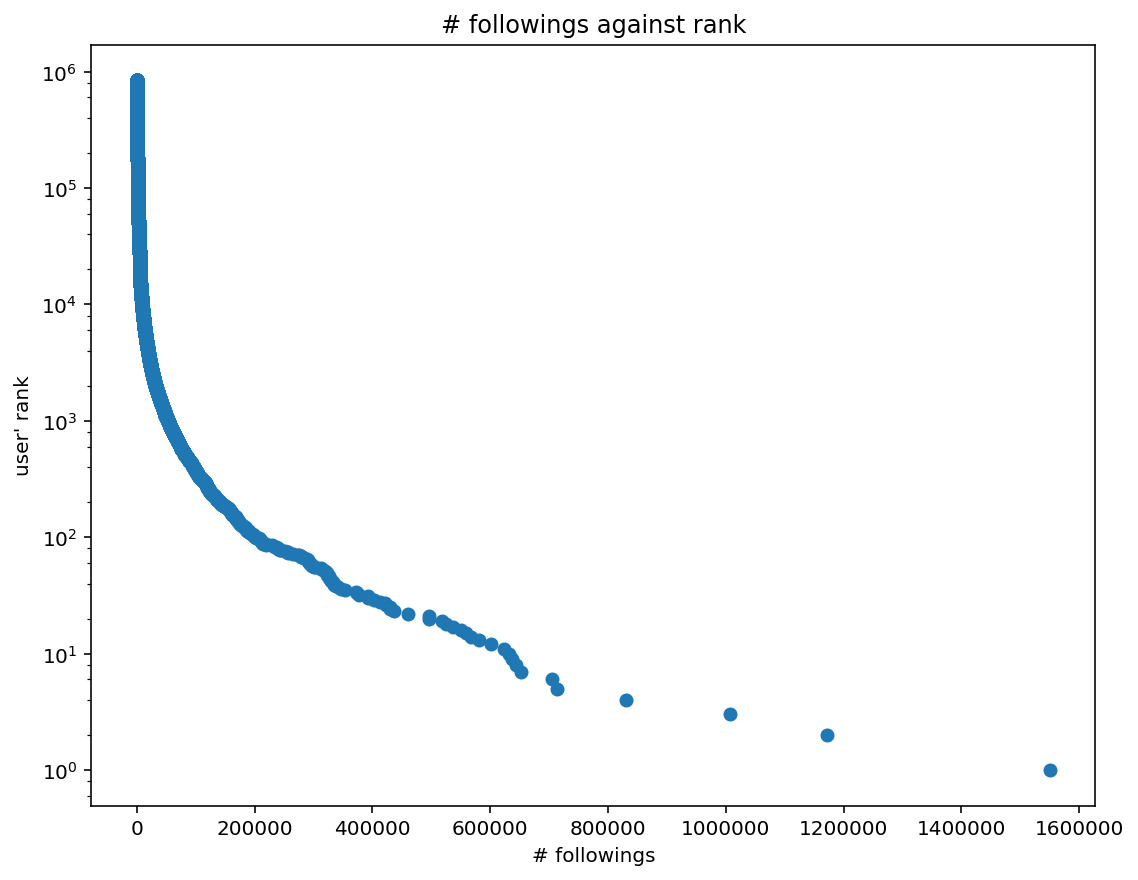

In [54]:
if 0 == 1:
    # plot and save figure   
    plt.figure(figsize=(9,7))
    plt.title('# followings against rank')
    plt.xlabel('# followings')
    plt.ylabel('user\' rank')
    plt.yscale('log')
    plt.scatter(x = df['friends_count'], y = df['friends_count_rank'])
    plt.savefig(friends_count_fig)